In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/oc-3-data/oc_3/train_3/oscc/aug_31_9370.jpg
/kaggle/input/oc-3-data/oc_3/train_3/oscc/aug_35_1039.jpg
/kaggle/input/oc-3-data/oc_3/train_3/oscc/aug_32_1799.jpg
/kaggle/input/oc-3-data/oc_3/train_3/normal/aug_163_170.jpg
/kaggle/input/oc-3-data/oc_3/train_3/normal/aug_198_9655.jpg
/kaggle/input/oc-3-data/oc_3/train_3/normal/aug_197_1339.jpg
/kaggle/input/oc-3-data/oc_3/test_3/oscc/OSCC_400x_113.jpg
/kaggle/input/oc-3-data/oc_3/test_3/oscc/OSCC_400x_110.jpg
/kaggle/input/oc-3-data/oc_3/test_3/oscc/OSCC_400x_112.jpg
/kaggle/input/oc-3-data/oc_3/test_3/normal/Normal_100x_83.jpg
/kaggle/input/oc-3-data/oc_3/test_3/normal/Normal_100x_72.jpg
/kaggle/input/oc-3-data/oc_3/test_3/normal/Normal_400x_12.jpg


In [2]:
import cv2
import keras
from keras import backend as K
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from keras.layers import Conv2D, Activation, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from keras.applications.resnet50 import preprocess_input, ResNet50
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
import shap
import tensorflow
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical

In [3]:
W = 112 # The default size for ResNet is 224 but resize to .5 to save memory size
H = 112 # The default size for ResNet is 224 but resize to .5 to save memory size
label_to_class = {
    'normal': 0,
    'oscc': 1
    
    
   
}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_images(dir_name='/kaggle/input/oc-3-data/oc_3/train_3', label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for label_name in os.listdir(dir_name):
        cls = label_to_class[label_name]
        
        for img_name in os.listdir('/'.join([dir_name, label_name])):
            img = load_img('/'.join([dir_name, label_name, img_name]), target_size=(W, H))
            img = img_to_array(img)
            
            Images.append(img)
            Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)
    
    return Images, Classes

In [4]:

Images, Classes = get_images()

Images.shape, Classes.shape

((6, 112, 112, 3), (6,))

normal 3 0.5


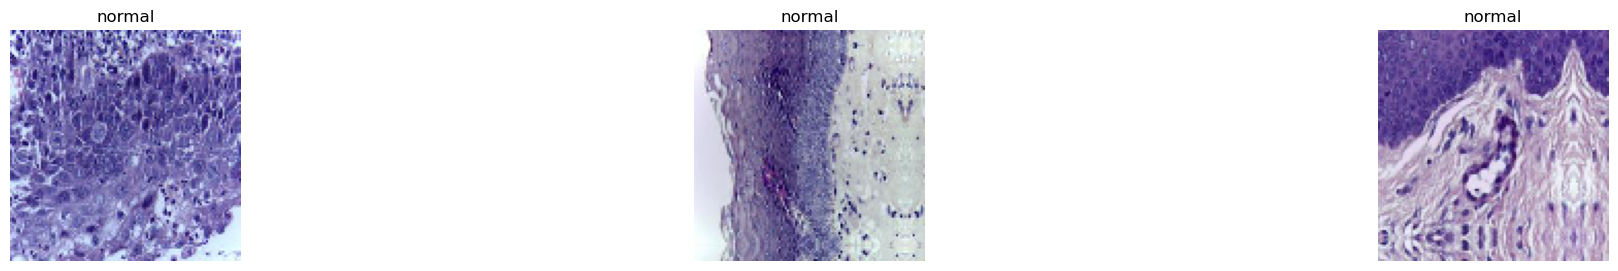

oscc 3 0.5


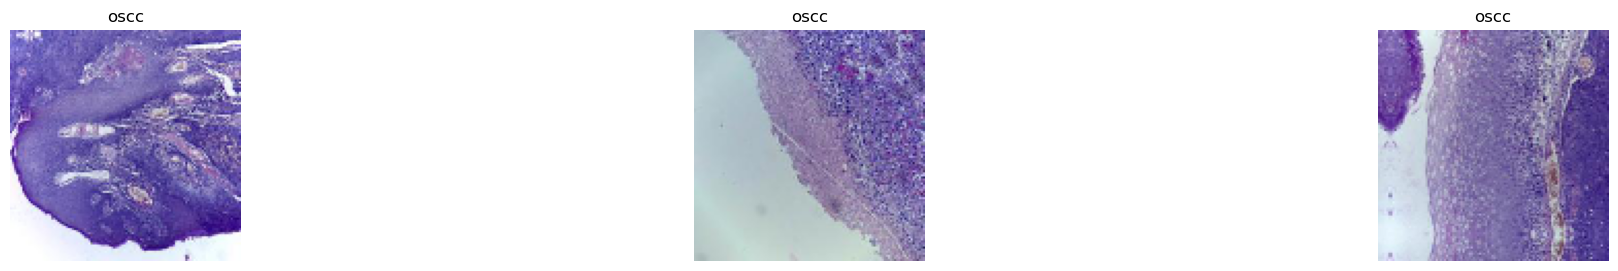

In [5]:
n_total_images = Images.shape[0]

for target_cls in [0, 1]:
    
    indices = np.where(Classes == target_cls)[0] # get target class indices on Images / Classes
    n_target_cls = indices.shape[0]
    label = class_to_label[target_cls]
    print(label, n_target_cls, n_target_cls/n_total_images)

    n_cols = 3 # # of sample plot
    fig, axs = plt.subplots(ncols=n_cols, figsize=(25, 3))

    for i in range(n_cols):

        axs[i].imshow(np.uint8(Images[indices[i]]))
        axs[i].axis('off')
        axs[i].set_title(label)

    plt.show()

In [6]:
indices_train, indices_test = train_test_split(list(range(Images.shape[0])), train_size=0.8, test_size=0.2, shuffle=False)

x_train = Images[indices_train]
y_train = Classes[indices_train]
x_test = Images[indices_test]
y_test = Classes[indices_test]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4, 112, 112, 3), (4,), (2, 112, 112, 3), (2,))

In [7]:
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

y_train.shape, y_test.shape

((4, 2), (2, 2))

In [8]:


from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input



In [9]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [10]:
from keras import layers

In [11]:
from tensorflow.keras.optimizers import Adam

In [12]:
def build_model():
    
    """build model function"""
    
    # inceptionv3
    input_tensor = Input(shape=(W, H, 3)) 
    inception = InceptionV3(
        include_top=False,                # To change output shape
        weights='imagenet',               # Use pre-trained model
        input_tensor=input_tensor,        # Change input shape for this task
    )
    
    for layer in inception.layers:
        layer.trainable = True

    inception_last_layer = inception.get_layer('mixed10')
    print('last layer output shape:', inception_last_layer.output_shape)
    inception_last_output = inception_last_layer.output



# Flatten the output layer to 1 dimension
    x_inception = layers.GlobalMaxPooling2D()(inception_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
    x_inception = layers.Dense(512, activation='relu')(x_inception)
# Add a dropout rate of 0.7
    x_inception = layers.Dropout(0.5)(x_inception)
# Add a final sigmoid layer for classification
    x_inception = layers.Dense(n_classes, activation='softmax')(x_inception)

          # Configure and compile the model

    inception_model = Model(input_tensor, x_inception)
    optimizer =  tf.keras.optimizers.legacy.Adam(learning_rate=0.000001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
    inception_model.compile(loss='binary_crossentropy',
                            optimizer=optimizer,
                            metrics=['accuracy'])
    return inception_model

    

In [13]:
inceptionmodel=build_model()

87910968/87910968 [==============================] - 3s 0us/step
last layer output shape: (None, 2, 2, 2048)


In [ ]:
inceptionmodel.summary()

In [ ]:
#inception = InceptionV3(input_shape=input_shape, input_tensor=model_input, include_top=False, weights=None)

In [14]:
from tensorflow.keras.applications.densenet import preprocess_input 
from tensorflow.keras.applications.densenet import DenseNet201

In [15]:
def build_model_two():
    
    input_tensor_two = Input(shape=(W, H, 3)) 
    denseNet = DenseNet201(
        include_top=False,                # To change output shape
        weights='imagenet',               # Use pre-trained model
        input_tensor=input_tensor_two,        # Change input shape for this task
    )
    
    for layer in denseNet.layers:
        layer.trainable = True

    denseNet_last_layer = denseNet.get_layer('relu')
    print('last layer output shape:', denseNet_last_layer.output_shape)
    denseNet_last_output = denseNet_last_layer.output



# Flatten the output layer to 1 dimension
    x_denseNet = layers.GlobalMaxPooling2D()(denseNet_last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
    x_denseNet = layers.Dense(512, activation='relu')(x_denseNet)
# Add a dropout rate of 0.7
    x_denseNet = layers.Dropout(0.5)(x_denseNet)
# Add a final sigmoid layer for classification
    x_denseNet = layers.Dense(n_classes, activation='softmax')(x_denseNet)

          # Configure and compile the model

    denseNet_model = Model(input_tensor_two, x_denseNet)
    optimizer = tf.keras.optimizers.legacy.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
    denseNet_model.compile(loss='binary_crossentropy',
                            optimizer=optimizer,
                            metrics=['accuracy'])
    return denseNet_model

    
 

    

In [16]:
denseNet_model=build_model_two()

74836368/74836368 [==============================] - 3s 0us/step
last layer output shape: (None, 3, 3, 1920)


The `lr` argument is deprecated, use `learning_rate` instead.


In [ ]:


denseNet_model.summary()



In [ ]:
#input_tensor = Input(shape=(W, H, 3)) 

In [ ]:


#ensemble_model = ensemble([denseNet_model, inceptionmodel], model_input=[denseNet_model.input,inceptionmodel.input])



In [17]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)

In [18]:
datagen_train = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    #rotation_range=30,                       # randomly rotate images in the range
    zoom_range=0.1,                          # Randomly zoom image
    width_shift_range=0.1,                   # randomly shift images horizontally
    height_shift_range=0.1,                  # randomly shift images vertically
    #horizontal_flip=True,                    # randomly flip images horizontally
    #vertical_flip=False,                     # randomly flip images vertically
)
datagen_test = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
)

In [19]:
enmodel = []
enmodel.append(build_model())
enmodel.append(build_model_two())

last layer output shape: (None, 2, 2, 2048)
last layer output shape: (None, 3, 3, 1920)


In [30]:
batch_size=2
epochs=7

In [21]:
from tensorflow import keras

In [22]:
from keras.callbacks import LearningRateScheduler,ReduceLROnPlateau

In [31]:
historys = []
annealer=[ReduceLROnPlateau(monitor='loss', patience=2, factor=0.1)],

for i in range(len(enmodel)):
    
    enmodel[i].compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    history=enmodel[i].fit_generator(datagen_train.flow(x_train,y_train, batch_size=batch_size),
                                        epochs = epochs, steps_per_epoch=x_train.shape[0] // batch_size,
                                        validation_data = datagen_test.flow(x_test,y_test,batch_size=batch_size),
                                        callbacks=[annealer],
                                        verbose=1
                                        ).history
    historys.append(enmodel[i])

`model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/7
2/2 [==============================] - 35s 10s/step - batch: 0.5000 - size: 2.0000 - loss: 0.3066 - accuracy: 1.0000 - val_loss: 1.8358 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/7
2/2 [==============================] - 1s 316ms/step - batch: 0.5000 - size: 2.0000 - loss: 0.8719 - accuracy: 0.7500 - val_loss: 1.9034 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/7
2/2 [==============================] - 1s 315ms/step - batch: 0.5000 - size: 2.0000 - loss: 0.1409 - accuracy: 1.0000 - val_loss: 1.7957 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/7
2/2 [==============================] - 1s 323ms/step - batch: 0.5000 - size: 2.0000 - loss: 0.1422 - accuracy: 1.0000 - val_loss: 1.6892 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/7
2/2 [==============================] - 9s 9s/step - batch: 0.5000 - size: 2.0000 - loss: 0.6836 - accuracy: 0.5000 - val_loss: 1.7325 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 6/7
2/2 [==============================] - 0s 297ms/step - batc

In [32]:
import copy

In [33]:
labels = []
for m in historys:
    x = preprocess_input(copy.deepcopy(x_test))
    y_preds = np.argmax(m.predict(x),axis=1)
    labels.append(y_preds)

In [ ]:
#np.transpose(labels).shape

In [34]:
print(y_preds)

[1 1]


In [35]:
print(labels)

[array([0, 0]), array([1, 1])]


In [36]:

import scipy

In [ ]:
#Ensemble voting

In [ ]:
#labels = np.array(labels)
#labels = np.transpose(labels, (1, 0))

In [ ]:
print(labels)

In [37]:
labels = np.array(labels)
labels = np.transpose(labels, (1, 0))
labels = scipy.stats.mode(labels, axis=1)[0]
labels = np.squeeze(labels)

In [ ]:
#labels=np.argmax(labels,axis=0)

In [ ]:
#labels=labels.reshape(1,0)

In [38]:
print(labels)

[0 0]


In [ ]:
pd.DataFrame({'ImageId' : np.arange(1, y_preds.shape[0] + 1), 'predLabel' : labels ,  }).to_csv('enop1.csv', index=False)

In [39]:
y_trues = np.argmax(y_test, axis=1)

In [40]:
print(y_trues)

[1 0]


In [56]:

from sklearn.metrics import confusion_matrix

In [ ]:
#y_true_labels = y_trues.reshape(-1,1)
#y_pred_labels  = labels.reshape(-1,1)

In [ ]:
#y_pred=np.argmax(labels, axis=0)

In [ ]:
#print(y_pred)

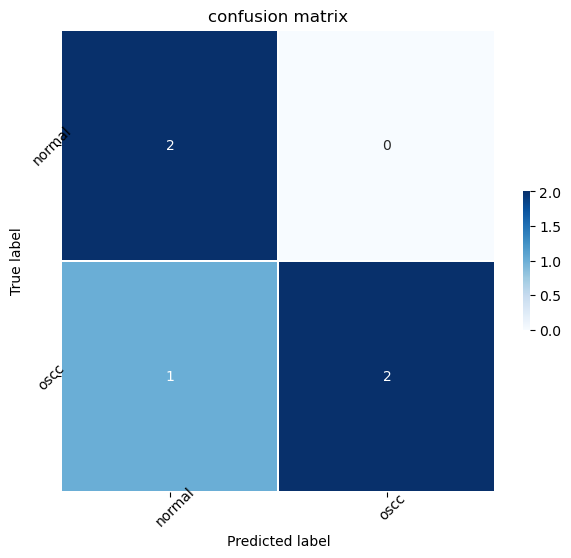

In [58]:
#y_pred = np.argmax(y_pred, axis=0)
#y_trues = np.argmax(y_test, axis=0)
cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


print('Precision: %.3f' % precision_score(y_trues,y_preds))
print('Recall: %.3f' % recall_score(y_trues,y_preds))
print('f1score: %.3f' % f1_score(y_trues,y_preds))
print('accuracy: %.3f' % accuracy_score(y_trues,y_preds))


In [ ]:
acc = historys[i].history.history['accuracy']
val_acc = historys[i].history.history['val_accuracy']
loss = historys[i].history.history['loss']
val_loss = historys[i].history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()

In [ ]:
fig = plt.figure(figsize=[15, 10])

for i in range(2):
    ax = fig.add_subplot(4, 2, i+1)
    
    ax.plot([None] + historys[i].history.history['accuracy'], 'o-')
    ax.plot([None] + historys[i].history.history['val_accuracy'], 'x-')
    
    ax.legend(['Train acc', 'Validation acc'], loc = 0)
    ax.set_title(f'Model {i+1} Training/Validation acc per Epoch')
    ax.set_xlabel('Epoch')
    plt.tight_layout()


In [ ]:
fig = plt.figure(figsize=[15, 10])

for i in range(2):
    ax = fig.add_subplot(4, 2, i+1)
    
    ax.plot([None] + historys[i].history.history['loss'], 'o-')
    ax.plot([None] + historys[i].history.history['val_loss'], 'x-')
    
    ax.legend(['Train loss', 'Validation loss'], loc = 0)
    ax.set_title(f'Model {i+1} Training/Validation loss per Epoch')
    ax.set_xlabel('Epoch')
    plt.tight_layout()


In [ ]:
#y_preds.shape

In [ ]:
#test


In [41]:
W = 112 # The default size for ResNet is 224 but resize to .5 to save memory size
H = 112 # The default size for ResNet is 224 but resize to .5 to save memory size
label_to_class = {
    'normal': 0,
    'oscc': 1
    
    
   
}
class_to_label = {v: k for k, v in label_to_class.items()}
n_classes = len(label_to_class)

def get_test_images(dir_name='/kaggle/input/oc-3-data/oc_3/test_3', label_to_class=label_to_class):
    """read images / labels from directory"""
    
    Images = []
    Classes = []
    
    for label_name in os.listdir(dir_name):
        cls = label_to_class[label_name]
        
        for img_name in os.listdir('/'.join([dir_name, label_name])):
            img = load_img('/'.join([dir_name, label_name, img_name]), target_size=(W, H))
            img = img_to_array(img)
            
            Images.append(img)
            Classes.append(cls)
            
    Images = np.array(Images, dtype=np.float32)
    Classes = np.array(Classes, dtype=np.float32)
    Images, Classes = shuffle(Images, Classes, random_state=0)
    
    return Images, Classes

In [42]:
Images, Classes = get_test_images()

Images.shape, Classes.shape

((6, 112, 112, 3), (6,))

normal 3 0.5


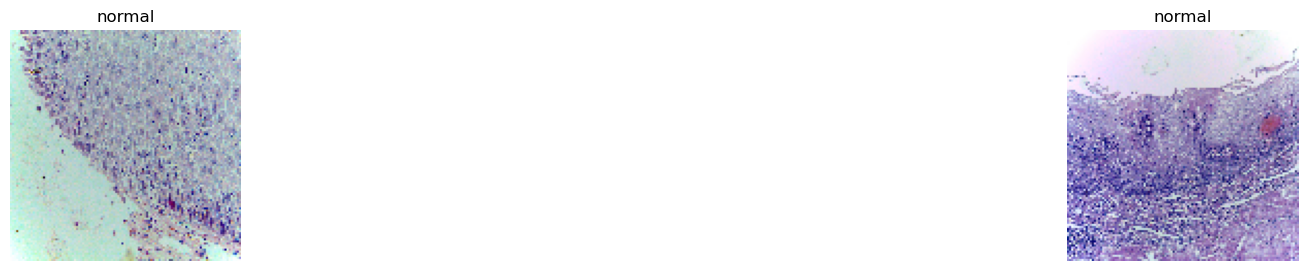

oscc 3 0.5


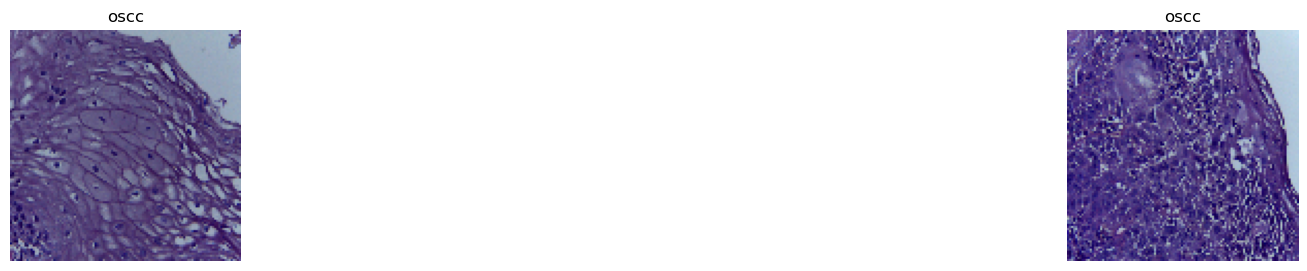

In [43]:
n_total_images = Images.shape[0]

for target_cls in [0, 1]:
    
    indices = np.where(Classes == target_cls)[0] # get target class indices on Images / Classes
    n_target_cls = indices.shape[0]
    label = class_to_label[target_cls]
    print(label, n_target_cls, n_target_cls/n_total_images)

    n_cols = 2 # # of sample plot
    fig, axs = plt.subplots(ncols=n_cols, figsize=(25, 3))

    for i in range(n_cols):

        axs[i].imshow(np.uint8(Images[indices[i]]))
        axs[i].axis('off')
        axs[i].set_title(label)

    plt.show()

In [ ]:
#ndices_test = list(range(Images.shape[0])

#x_train = Images[indices_train]
#y_train = Classes[indices_train]
#x_test = list(range(Images.shape[0])
#y_test = 

#y_test.shape

In [44]:
datagen_test2 = ImageDataGenerator(
    preprocessing_function=preprocess_input, # image preprocessing function
    #rotation_range=30,                       # randomly rotate images in the range
    zoom_range=0.1,                          # Randomly zoom image
    width_shift_range=0.1,                   # randomly shift images horizontally
    height_shift_range=0.1,                  # randomly shift images vertically
    #horizontal_flip=True,                    # randomly flip images horizontally
    #vertical_flip=False,                     # randomly flip images vertically
)

In [45]:
indices_train, indices_test = train_test_split(list(range(Images.shape[0])), train_size=0.2, test_size=0.8, shuffle=False)

x_train = Images[indices_train]
y_train = Classes[indices_train]
x_test = Images[indices_test]
y_test = Classes[indices_test]

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1, 112, 112, 3), (1,), (5, 112, 112, 3), (5,))

In [46]:
y_train = to_categorical(y_train, n_classes)
y_test = to_categorical(y_test, n_classes)

y_train.shape, y_test.shape

((1, 2), (5, 2))

In [ ]:
#from keras.utils import to_categorical
#y_binary = to_categorical(Classes)

In [ ]:
#y_binary.shape

In [ ]:
#x_binary=to_categorical(Images)

In [ ]:
#x_binary.shape

In [47]:
historys = []
annealer=[ReduceLROnPlateau(monitor='loss', patience=3, factor=0.1)],

for i in range(len(enmodel)):
    
    enmodel[i].compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    
    history=enmodel[i].evaluate(datagen_test2.flow(x_test,y_test, batch_size=batch_size),
                                        callbacks=[annealer],
                                        verbose=2
                                        )
    historys.append(enmodel[i])

In [48]:
labels = []
for m in historys:
    x = preprocess_input(copy.deepcopy(x_test))
    y_preds = np.argmax(m.predict(x),axis=1)
    labels.append(y_preds)

In [49]:
print(y_preds)

[0 1 0 1 0]


In [50]:
import scipy

In [ ]:
labels = np.array(labels)
labels = np.transpose(labels, (1, 0))
labels = scipy.stats.mode(labels, axis=1)[0]
labels = np.squeeze(labels)

In [ ]:
#final

In [ ]:
print(labels)

In [51]:
y_trues = np.argmax(y_test, axis=1)

In [52]:
print(y_trues)


[1 1 0 1 0]


In [53]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


print('Precision: %.3f' % precision_score(y_trues,y_preds))
print('Recall: %.3f' % recall_score(y_trues,y_preds))
print('f1score: %.3f' % f1_score(y_trues,y_preds))
print('f1score: %.3f' % f1_score(y_trues,y_preds))

Precision: 1.000
Recall: 0.667
f1score: 0.800
f1score: 0.800


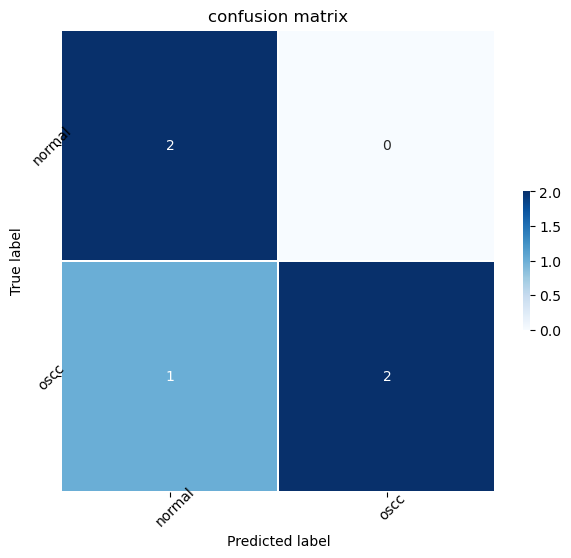

In [54]:
cm = confusion_matrix(y_trues, y_preds)

fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar_kws={'shrink': .3}, linewidths=.1, ax=ax)

ax.set(
    xticklabels=list(label_to_class.keys()),
    yticklabels=list(label_to_class.keys()),
    title='confusion matrix',
    ylabel='True label',
    xlabel='Predicted label'
)
params = dict(rotation=45, ha='center', rotation_mode='anchor')
plt.setp(ax.get_yticklabels(), **params)
plt.setp(ax.get_xticklabels(), **params)
plt.show()

In [ ]:
acc = historys[i].history.history['accuracy']
#val_acc = historys[i].history.history['val_accuracy']
#loss = historys[i].history.history['loss']
#val_loss = historys[i].history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy', color='r')
#plt.plot(val_acc, label='Validation Accuracy', color='b')


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
#plt.title('Training & Validation Acc.', fontsize=16, weight='bold')

#plt.subplot(2, 1, 2)
#plt.plot(loss, label='Training Loss', color='r')
#plt.plot(val_loss, label='Validation Loss', color='b')
#plt.xticks(fontsize=14)
#plt.yticks(fontsize=14)
#plt.legend(loc='upper right', fontsize=13)
#plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
#plt.title('Training & Validation Loss', fontsize=15, weight='bold')
#plt.xlabel('Epoch', fontsize=15, weight='bold')
plt.show()

In [ ]:
fig = plt.figure(figsize=[15, 10])

for i in range(2):
    ax = fig.add_subplot(4, 2, i+1)
    
    ax.plot([None] + historys[i].history.history['accuracy'], 'o-')
    ax.plot([None] + historys[i].history.history['val_accuracy'], 'x-')
    
    ax.legend(['Train acc', 'Validation acc'], loc = 0)
    ax.set_title(f'Model {i+1} Training/Validation acc per Epoch')
    ax.set_xlabel('Epoch')
    plt.tight_layout()


In [ ]:
fig = plt.figure(figsize=[15, 10])

for i in range(2):
    ax = fig.add_subplot(4, 2, i+1)
    
    ax.plot([None] + historys[i].history.history['loss'], 'o-')
    ax.plot([None] + historys[i].history.history['val_loss'], 'x-')
    
    ax.legend(['Train loss', 'Validation loss'], loc = 0)
    ax.set_title(f'Model {i+1} Training/Validation loss per Epoch')
    ax.set_xlabel('Epoch')
    plt.tight_layout()
